📌 week11 과제는 **11주차의 Transformer Model 실습**으로 구성되어 있습니다.

📌 위키독스의 딥러닝을 이용한 자연어 처리 입문 교재 실습 등의 문서 자료로 구성되어 있는 과제입니다. 

📌 안내된 링크에 맞추어 **직접 코드를 따라 치면서 (필사)** 해당 nlp task 의 기본적인 라이브러리와 메서드를 숙지해보시면 좋을 것 같습니다😊

📌 궁금한 사항은 깃허브 이슈나, 카톡방, 세션 발표 시작 이전 시간 등을 활용하여 자유롭게 공유해주세요!

### **Transformer Model**

👀 **내용 복습** 
* Transformer Model은 기존의 seq2seq의 단점인 정보 손실을 최소화하여 더 좋은 성능을 보여줍니다.

* Transformer Model 설명 참고 자료
 * [Transformer 살펴보기](https://ratsgo.github.io/nlpbook/docs/language_model/transformers/)


🥰 **아래의 내용을 필사하면서 내용을 이해하는 방식으로 실습하시면 됩니다.**

🔹 **1-(1). Transformer 코드로 구현**해보기

* Transformer model을 파이썬 코드로 구현해보는 실습입니다. 
* 'Attention Is All You Need' 논문을 읽으신 후에 구현해 보면 논문 내용 이해에 더욱 도움이 되실 것입니다.

📌  [Transformer 코드 구현](https://wikidocs.net/31379)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


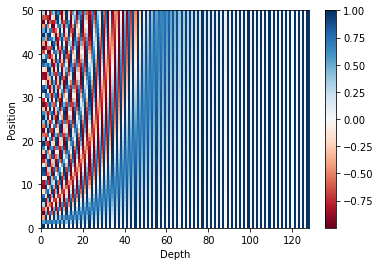

In [8]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [9]:
def scaled_dot_product_attention(query, key, value, mask):
  matmul_qk = tf.matmul(query, key, transpose_b=True)
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  if mask is not None:
    logits += (mask * -1e9)
  attention_weights = tf.nn.softmax(logits, axis=-1)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [10]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

In [11]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn)
print(temp_out)

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [12]:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)

SyntaxError: ignored

In [13]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) 
print(temp_out) 

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [14]:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)

SyntaxError: ignored

In [15]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) 
print(temp_out) 

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [16]:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)

SyntaxError: ignored

🔹 **1-(2). 트랜스포머를 이용한 한국어 챗봇 구현**해보기

* 앞의 1-(1) 코드 작성을 전제로 하므로, 위의 Transformer 코드 구현 후 실습하시면 됩니다.
* 일상 대화 챗봇을 구현하는 실습입니다.

📌 [트랜스포머를 이용한 한국어 챗봇](https://wikidocs.net/89786) 








In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 11823


In [4]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [5]:
questions = []
for sentence in train_data['Q']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [6]:
answers = []
for sentence in train_data['A']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [7]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [8]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [9]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

VOCAB_SIZE = tokenizer.vocab_size + 2

In [10]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)


시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [11]:
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))

임의의 질문 샘플을 정수 인코딩 : [5766, 611, 3509, 141, 685, 3747, 849]


In [12]:
sample_string = questions[20]

tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5766, 611, 3509, 141, 685, 3747, 849]
기존 문장: 가스비 비싼데 감기 걸리겠어


In [13]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
3509 ----> 비싼
141 ----> 데 
685 ----> 감기 
3747 ----> 걸리
849 ----> 겠어


In [14]:
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [15]:
questions, answers = tokenize_and_filter(questions, answers)


In [16]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


In [17]:
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
print(answers[0]) 
print(answers[:1][:, :-1]) 
print(answers[:1][:, 1:]) 

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [20]:
tf.keras.backend.clear_session()

D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

NameError: ignored

In [21]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

NameError: ignored

In [22]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)

NameError: ignored